In [85]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matlab.engine
m = matlab.engine.connect_matlab('RLengine')

t_pause = 0.0001 #This needs to match the simulation pausing block parameter


EngineError: Unable to connect to MATLAB session 'RLengine'.

In [186]:
def update_control(mainPWM, PWM1, PWM2, PWM3):
    freq = m.workspace['f']
    #Main PWM
    delay_main = mainPWM / freq
    m.set_param(m.workspace['var_D_main'],'Value',str(mainPWM), nargout=0)
    m.set_param(m.workspace['var_D_main_n'],'Value',str(1-mainPWM), nargout=0)
    m.set_param(m.workspace['var_D_main_PWM'],'Tdelay',str(0), nargout=0)
    m.set_param(m.workspace['var_D_main_n_PWM'],'Tdelay',str(delay_main), nargout=0)

    delay_PWM1 = 0
    delay_PWM2 = PWM1 / freq
    delay_PWM3 = (PWM1+PWM2) / freq
    #PWM
    m.set_param(m.workspace['var_D_si_1'],'Value',str(PWM1), nargout=0)
    m.set_param(m.workspace['var_D_si_2'],'Value',str(PWM2), nargout=0)
    m.set_param(m.workspace['var_D_si_3'],'Value',str(PWM3), nargout=0)
    #Delay
    m.set_param(m.workspace['var_D_si_1_PWM'],'Tdelay',str(delay_PWM1), nargout=0)
    m.set_param(m.workspace['var_D_si_2_PWM'],'Tdelay',str(delay_PWM2), nargout=0)
    m.set_param(m.workspace['var_D_si_3_PWM'],'Tdelay',str(delay_PWM3), nargout=0)

def update_load(load1, load2, load3):
    m.set_param(m.workspace['source_1'],'i0',str(load1), nargout=0)
    m.set_param(m.workspace['source_2'],'i0',str(load2), nargout=0)
    m.set_param(m.workspace['source_3'],'i0',str(load3), nargout=0)
def action_to_control(current_PWM, action):
    # In this verion, the control value simply tells the PWM to go up or go down
    for PWM_id in range(4):
        current_PWM[PWM_id] = action[PWM_id]
    return current_PWM
class PMICModel():
    #namedtuple('Values', ['power','HD1','HD2','HD3','THD'])
    def __init__(self, desired_V, init_PWM, init_load):
        self.desired_V = desired_V
        self.init_PWM = init_PWM
        self.init_load = init_load

        self.mainPWM = init_PWM[0]
        self.PWM1 = init_PWM[1]
        self.PWM2 = init_PWM[2]
        self.PWM3 = init_PWM[3]

        load1 = init_load[0]
        load2 = init_load[1]
        load3 = init_load[2]

        self.current_V = [0,0,0]
        self.prev_V = [0,0,0]
        self.current_PWM = init_PWM
        #Run startup transient
        self.reset()

        #
    def reset(self, desired_V=None, init_PWM=None, init_load=None):
        if desired_V != None:
            self.desired_V = desired_V
        if init_PWM != None:
            self.init_PWM = init_PWM
        if init_load != None:
            self.init_load = init_load

        m.set_param(m.workspace['mdl'],'SimulationCommand','stop',nargout=0)
        #init control values
        update_control(self.init_PWM[0],self.init_PWM[1],self.init_PWM[2],self.init_PWM[3])
        update_load(self.init_load[0], self.init_load[1], self.init_load[2])
        #run startup transient
        m.set_param(m.workspace['mdl'],'SimulationCommand','start',nargout=0)
        m.set_param(m.workspace['mdl'],'SimulationCommand','continue',nargout=0)
        time.sleep(1)
        #print(m.eval("out.tout"))
        #while (m.eval("out.tout")[-1][0] % t_pause != 0):
        #    pass
        while (m.get_param(m.workspace['mdl'], 'SimulationStatus') != 'paused'):
            pass
        #Get current V
        #print(self.current_V)
        #print(np.array(m.eval("out.yout{1}.Values.Data")))
        self.current_V[0] = np.array(m.eval("out.yout{1}.Values.Data"))[0,0,:][-1]
        self.current_V[1] = np.array(m.eval("out.yout{2}.Values.Data"))[0,0,:][-1]
        self.current_V[2] = np.array(m.eval("out.yout{3}.Values.Data"))[0,0,:][-1]
        self.current_PWM = self.init_PWM
    def change_load(self, new_load):
        update_load(new_load[0], new_load[1], new_load[2])
        m.set_param(m.workspace['mdl'],'SimulationCommand','update',nargout=0)
        m.set_param(m.workspace['mdl'],'SimulationCommand','continue',nargout=0)
        #Let the simulation run while check time
        while m.get_param(m.workspace['mdl'], 'SimulationStatus') != 'paused':
            pass
        self.current_V[0] = np.array(m.eval("out.yout{1}.Values.Data"))[0,0,:][-1]
        self.current_V[1] = np.array(m.eval("out.yout{2}.Values.Data"))[0,0,:][-1]
        self.current_V[2] = np.array(m.eval("out.yout{3}.Values.Data"))[0,0,:][-1]
    def step(self, action):
        #Record prev V
        self.prev_V = self.current_V

        ###Action:
        self.current_PWM = action_to_control(self.current_PWM, action) #use NN output action to update PWM
        update_control(self.current_PWM [0],self.current_PWM [1],self.current_PWM [2],self.current_PWM [3])
        #Updating the load should be an externel random event
        #update_load(init_load[0], init_load[1], init_load[2])
        # Continue the work
        m.set_param(m.workspace['mdl'],'SimulationCommand','continue',nargout=0)
        #Let the simulation run while check time
        while m.get_param(m.workspace['mdl'], 'SimulationStatus') != 'paused':
            pass
        # Simulation will be paused here. Now the check the new Vout

        self.current_V[0] = np.array(m.eval("out.yout{1}.Values.Data"))[0,0,:][-1]
        self.current_V[1] = np.array(m.eval("out.yout{2}.Values.Data"))[0,0,:][-1]
        self.current_V[2] = np.array(m.eval("out.yout{3}.Values.Data"))[0,0,:][-1]
        self.current_PWM = self.init_PWM
        #TODO: Reward Function
        reward = 0.5
        #done = noAction
        done = 0
        return self.current_V, reward, done, 1
        # I am thinking about making the state [current PWM*4, prev V * 3, current V*3]
    def return_state(self):
        return self.state

In [187]:
desired_V = [3.3, 1.8, 1.2]
init_PWM = [0.5, 0.3,0.4,0.5] #Main, 1, 2, 3
init_load = [10,10,10]
env = PMICModel(desired_V, init_PWM, init_load)

In [188]:
print(env.current_V)

[1.5434923190233676, 1.8528737746371169, 1.6672717808516764]


In [189]:
sig_len = 8
V0 = []
V1 = []
V2 = []

In [191]:
for i in range(sig_len):
    V_new,_,_,_ = env.step([0.5, 0.3,0.4,0.5])
    V0.append(V_new[0])
    V1.append(V_new[1])
    V2.append(V_new[2])

In [195]:
for i in range(sig_len):
    env.change_load([100,100,100])
    V0.append(env.current_V[0])
    V1.append(env.current_V[1])
    V2.append(env.current_V[2])

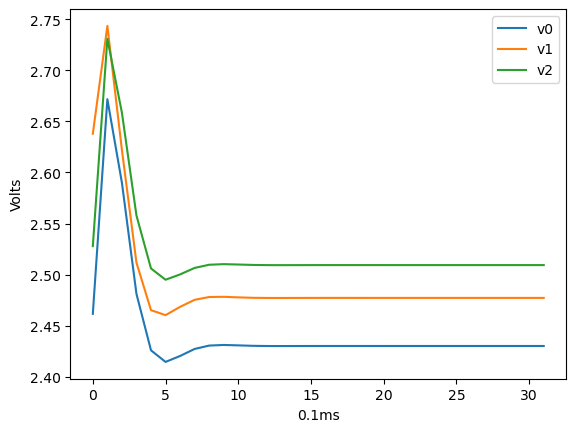

In [196]:
plt.plot(V0)
plt.plot(V1)
plt.plot(V2)
plt.ylabel("Volts")
plt.xlabel("0.1ms")
plt.legend(["v0","v1","v2"])
plt.show()

In [28]:
while (m.eval("out.tout")[-1][0] % t_pause != 0):
    print(m.eval("out.tout")[-1])
    time.sleep(0.1)
    pass

In [56]:
np.array(m.eval("out.yout{1}.Values.Data"))[0,0,:][-1]

2.429031792819656

'paused'